**Table of contents**<a id='toc0_'></a>    
- [Logs for the methylation data app](#toc1_)    
  - [Introduction](#toc1_1_)    
    - [21-11-2024](#toc1_1_1_)    
  - [Loading in the data](#toc1_2_)    
    - [21-11-2024](#toc1_2_1_)    
  - [Data exploration](#toc1_3_)    
    - [22-11-2024](#toc1_3_1_)    
    - [25-11-2024](#toc1_3_2_)    
  - [BED file annotation](#toc1_4_)    
    - [26-11-2024](#toc1_4_1_)    
  - [28-11-2024](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Logs for the methylation data app](#toc0_)

## <a id='toc1_1_'></a>[Introduction](#toc0_)
### <a id='toc1_1_1_'></a>[21-11-2024](#toc0_)

This logbook will describe the process of creating visualisations, ideas. These visualisations and ideas will be used to create an application for research students.
This application will take DNA methylation data as input. This app will make it easier for the students to look into their generated data, and it will help them with understanding their data.


## <a id='toc1_2_'></a>[Loading in the data](#toc0_)
### <a id='toc1_2_1_'></a>[21-11-2024](#toc0_)

I would like to combine the data from all the files into one single file, with the id in the column of the df.
This way i could compare different conditions to eachother.

The first code-block is to load in the used libraries.

In [57]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
from Bio import SeqIO
import pandas as pd
import re

In [58]:
barcodes_names: pl.dataframe = pl.read_csv("/commons/Themas/Thema06/Methylatie/barcodes.csv")

barcodes_names = barcodes_names.with_columns(controle_n = pl.int_range(pl.len()).over(" description")+1)
barcodes_names = barcodes_names.with_columns(group_and_n = pl.concat_str([pl.col(' description'), pl.col("controle_n")]))

barcodes_names = barcodes_names.with_columns(pl.col(pl.Utf8).str.strip_chars()).drop("controle_n")

print(barcodes_names)



shape: (5, 3)
┌─────────┬─────────────────────┬──────────────────────┐
│ barcode ┆  description        ┆ group_and_n          │
│ ---     ┆ ---                 ┆ ---                  │
│ i64     ┆ str                 ┆ str                  │
╞═════════╪═════════════════════╪══════════════════════╡
│ 11      ┆ Jurkat_DMSO_control ┆ Jurkat_DMSO_control1 │
│ 12      ┆ Jurkat_betuline     ┆ Jurkat_betuline1     │
│ 13      ┆ Healthy_control     ┆ Healthy_control1     │
│ 14      ┆ Jurkat_betuline     ┆ Jurkat_betuline2     │
│ 15      ┆ Jurkat_DMSO_control ┆ Jurkat_DMSO_control2 │
└─────────┴─────────────────────┴──────────────────────┘


This generates a data frame that contains the barcode and also the description of the barcode
The column called group_and_n contains the description with a control group number

This is needed to label the different groups in the df that will contain all of the data

Which will be loaded in the code below this block

In [59]:
path: str = "/commons/Themas/Thema06/Methylatie/analysis"
def load_files(path: str) -> pl.dataframe:
    resulting_df: pd.DataFrame = pl.DataFrame(
        {"chr":[],
         "start":[],
         "end":[],
         "frac":[],
         "valid":[],
         "group_name":[]}
    )
    files: list[str] = os.listdir(path)

    for file in files:
        if os.path.isfile(f"{path}/{file}") and file.endswith("methylatie_ALL.csv"):
            temp_df: pd.DataFrame = pd.read_csv(f"{path}/{file}", sep="\t")
            temp_df: pl.DataFrame = pl.from_pandas(temp_df)
            barcode_num: list[int] = re.findall(r"\d+", file)

            name_group: str = barcodes_names.filter(pl.col("barcode").cast(pl.String) == barcode_num[0]).select("group_and_n")
            temp_df: pl.DataFrame = temp_df.with_columns(pl.lit(name_group).alias("group_name"))
            resulting_df = pl.concat([temp_df, resulting_df])
    
    return resulting_df
    
df: pl.DataFrame = load_files(path=path)

All of the csv files are now loaded into 1 polars dataframe

In [60]:
print(df.head())

shape: (5, 6)
┌──────┬───────┬───────┬──────┬───────┬──────────────────┐
│ chr  ┆ start ┆ end   ┆ frac ┆ valid ┆ group_name       │
│ ---  ┆ ---   ┆ ---   ┆ ---  ┆ ---   ┆ ---              │
│ str  ┆ i64   ┆ i64   ┆ f64  ┆ i64   ┆ str              │
╞══════╪═══════╪═══════╪══════╪═══════╪══════════════════╡
│ chr1 ┆ 10468 ┆ 10469 ┆ 1.0  ┆ 1     ┆ Jurkat_betuline2 │
│ chr1 ┆ 10470 ┆ 10471 ┆ 1.0  ┆ 2     ┆ Jurkat_betuline2 │
│ chr1 ┆ 10488 ┆ 10489 ┆ 1.0  ┆ 2     ┆ Jurkat_betuline2 │
│ chr1 ┆ 10492 ┆ 10493 ┆ 1.0  ┆ 2     ┆ Jurkat_betuline2 │
│ chr1 ┆ 10496 ┆ 10497 ┆ 1.0  ┆ 1     ┆ Jurkat_betuline2 │
└──────┴───────┴───────┴──────┴───────┴──────────────────┘


## <a id='toc1_3_'></a>[Data exploration](#toc0_)
### <a id='toc1_3_1_'></a>[22-11-2024](#toc0_)
I now have a data frame with the methylation data with a column called group_name that holds the name of the group of which the data comes from

In [61]:
test: pl.DataFrame = df.filter(
    pl.col("group_name").is_in(['Healthy_control1', 'Jurkat_betuline1', 'Jurkat_betuline2'])
)
test: pl.DataFrame = df.filter((pl.col("start") >= 60778131) & 
                   (pl.col("end") <= 60778731) & 
                   (pl.col("chr") == "chr10"))
print(test)

shape: (83, 6)
┌───────┬──────────┬──────────┬──────┬───────┬──────────────────┐
│ chr   ┆ start    ┆ end      ┆ frac ┆ valid ┆ group_name       │
│ ---   ┆ ---      ┆ ---      ┆ ---  ┆ ---   ┆ ---              │
│ str   ┆ i64      ┆ i64      ┆ f64  ┆ i64   ┆ str              │
╞═══════╪══════════╪══════════╪══════╪═══════╪══════════════════╡
│ chr10 ┆ 60778212 ┆ 60778213 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ chr10 ┆ 60778217 ┆ 60778218 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ chr10 ┆ 60778237 ┆ 60778238 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ chr10 ┆ 60778258 ┆ 60778259 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ chr10 ┆ 60778283 ┆ 60778284 ┆ 0.0  ┆ 1     ┆ Jurkat_betuline2 │
│ …     ┆ …        ┆ …        ┆ …    ┆ …     ┆ …                │
│ chr10 ┆ 60778682 ┆ 60778683 ┆ 0.0  ┆ 3     ┆ Healthy_control1 │
│ chr10 ┆ 60778689 ┆ 60778690 ┆ 0.0  ┆ 3     ┆ Healthy_control1 │
│ chr10 ┆ 60778700 ┆ 60778701 ┆ 0.0  ┆ 3     ┆ Healthy_control1 │
│ chr10 ┆ 60778707 ┆ 60778708 ┆ 0.0  ┆ 3     ┆ Healthy_contro

This df contains all methylation data between the range of 60778131 and 60778731 on chr 10 (CDK1).
This is a possible way to filter for all the methylated DNA in a range.
This is also filtered for 3 selected groups.

In [62]:
all_groups = pl.DataFrame({"group_name": df["group_name"].unique()})

test_agg: pl.DataFrame = (
    test
    .select(["group_name", "frac"])
    .group_by("group_name")
    .agg([pl.len().alias("n methylations")])
    .join(all_groups, on="group_name", how="full")
    .with_columns(pl.col("group_name").fill_null(pl.col("group_name_right")))
    .drop("group_name_right") 
    .fill_null(0)
)
print(test_agg)


shape: (5, 2)
┌──────────────────────┬────────────────┐
│ group_name           ┆ n methylations │
│ ---                  ┆ ---            │
│ str                  ┆ u32            │
╞══════════════════════╪════════════════╡
│ Jurkat_betuline2     ┆ 39             │
│ Jurkat_DMSO_control1 ┆ 0              │
│ Jurkat_betuline1     ┆ 0              │
│ Jurkat_DMSO_control2 ┆ 0              │
│ Healthy_control1     ┆ 44             │
└──────────────────────┴────────────────┘


This df contains the number of methylations in the range specified in the test df.
It appears that there's only methylations for the healthy control group and 1 of the 2 betuline control groups.
These results overlap with the results found by the students for this gene (CDK1).

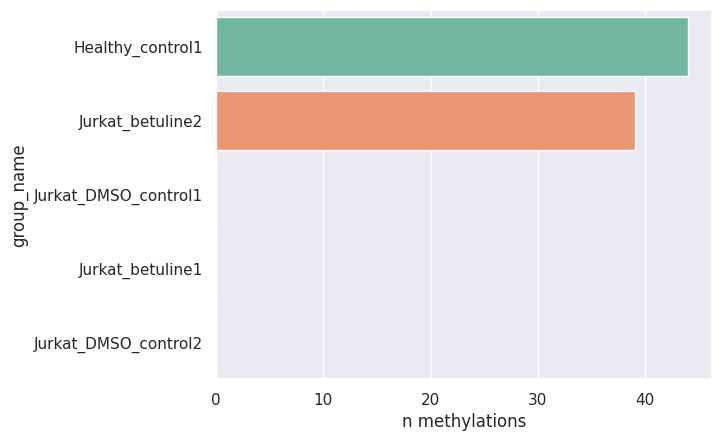

In [63]:
sns.set_theme()

sns.barplot(data = test_agg.sort("n methylations", descending=True),
            y = "group_name", x = "n methylations",
            hue="group_name", palette="Set2")
plt.show()

This plot showcases the amount of methylations for a certain gene (CDK1).
It appears that there's only methylated DNA for 2 groups.

These results overlap with the research and processing of the data that the research students have done. 

### <a id='toc1_3_2_'></a>[25-11-2024](#toc0_)
- Extra md explanation for code above this block.

The following thing i would like to check is if the difference between end and start are always 1.
This is to check if there is any possibly faulty data.


In [64]:
start_end_diff: pl.DataFrame = (
    df
    .filter(pl.col("end") - pl.col("start") != 1)
)
print(start_end_diff)

shape: (0, 6)
┌─────┬───────┬─────┬──────┬───────┬────────────┐
│ chr ┆ start ┆ end ┆ frac ┆ valid ┆ group_name │
│ --- ┆ ---   ┆ --- ┆ ---  ┆ ---   ┆ ---        │
│ str ┆ i64   ┆ i64 ┆ f64  ┆ i64   ┆ str        │
╞═════╪═══════╪═════╪══════╪═══════╪════════════╡
└─────┴───────┴─────┴──────┴───────┴────────────┘


This ouput means that the difference between end and start is always equal to 1.
This means that there are no faulty positions.

I would like to see if there are any major differences between the different groups and the amount of methylated DNA.

In [65]:
df_n_methylation: pl.DataFrame = (
    df
    .select("group_name")
    .group_by("group_name")
    .agg([pl.len().alias("n methylations")])
)
print(df_n_methylation.head())

shape: (5, 2)
┌──────────────────────┬────────────────┐
│ group_name           ┆ n methylations │
│ ---                  ┆ ---            │
│ str                  ┆ u32            │
╞══════════════════════╪════════════════╡
│ Jurkat_DMSO_control1 ┆ 2541070        │
│ Jurkat_betuline2     ┆ 2654900        │
│ Jurkat_betuline1     ┆ 1994070        │
│ Healthy_control1     ┆ 14820163       │
│ Jurkat_DMSO_control2 ┆ 2272843        │
└──────────────────────┴────────────────┘


This table holds the total amount of methylations.
Visualising this table would make it easier to see any possible differences.

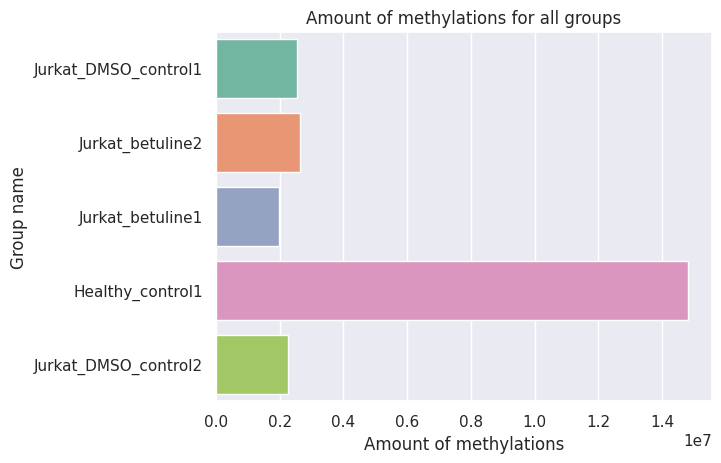

In [66]:
sns.barplot(data = df_n_methylation,
            y = "group_name", x = "n methylations",
            hue="group_name", palette="Set2",).set(
                title="Amount of methylations for all groups",
                xlabel="Amount of methylations", ylabel = "Group name")
plt.show()

This plot visualises the amount of methylations for every group that is part of the experiment.
The x-axis holds the number of methylations, while the y-axis holds the name of the group that the number belongs to.

This plot clearly showcases that the healthy control group has way more methylations then the other groups.
This implies that the other groups might have some sort of effect on the methylation.
It is unclear if this is the betuline, the DMSO control group also appears to impact the methylation.

I could possibly zoom more into to other groups, to visualise the differences between the treated groups.

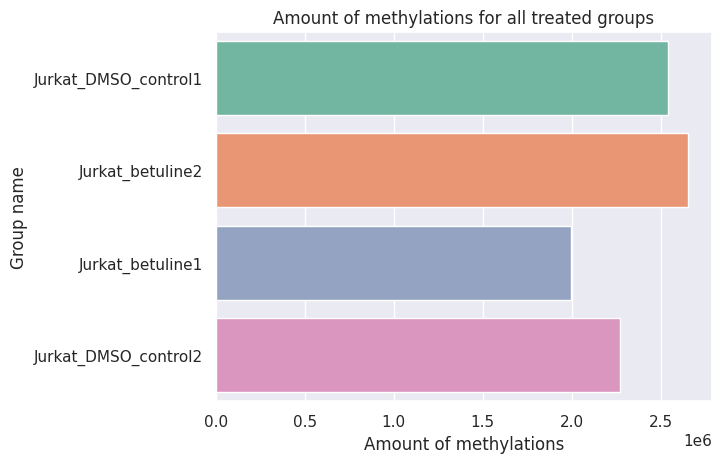

In [67]:
sns.barplot(data = df_n_methylation.filter(pl.col("group_name") != "Healthy_control1"),
            y = "group_name", x = "n methylations",
            hue="group_name", palette="Set2",).set(
                title="Amount of methylations for all treated groups",
                xlabel="Amount of methylations", ylabel = "Group name")
plt.show()

This plot visualises the amount of methylations for every group that is part of the experiment.
The x-axis holds the number of methylations, while the y-axis holds the name of the group that the number belongs to.

This visualises that there does not appear to be a pattern between and inside of groups.
To make data selection i need to do the following:
- Give the given bedfile gene symbols to easier look for specific genes

I will clean the bedfile first, it is very inconsistant with tabs and spaces.

## <a id='toc1_4_'></a>[BED file annotation](#toc0_)
### <a id='toc1_4_1_'></a>[26-11-2024](#toc0_)

In [68]:
path_bed = "/commons/Themas/Thema06/Methylatie/RRMS_human_hg38.bed"
file_cleaned = []
with open(path_bed, 'r') as bed_file:
    for line in bed_file:
        replaced_line = re.sub(r"\s+", "\t", line.strip())

        file_cleaned.append(replaced_line)
with open("../data/new_bed_file.bed", "w") as new_bed:
    new_bed.write("chr\tstart\tend\n")
    new_bed.write("\n".join(file_cleaned))

In [69]:

bed_df = pl.from_pandas(pd.read_csv("../data/new_bed_file.bed", sep="\t"))
print(bed_df)

shape: (18_069, 3)
┌───────┬──────────┬──────────┐
│ chr   ┆ start    ┆ end      │
│ ---   ┆ ---      ┆ ---      │
│ str   ┆ i64      ┆ i64      │
╞═══════╪══════════╪══════════╡
│ chr1  ┆ 24735    ┆ 33737    │
│ chr1  ┆ 131124   ┆ 139563   │
│ chr1  ┆ 195251   ┆ 204121   │
│ chr1  ┆ 364792   ┆ 386185   │
│ chr1  ┆ 487107   ┆ 495546   │
│ …     ┆ …        ┆ …        │
│ chr18 ┆ 59898996 ┆ 59900196 │
│ chr19 ┆ 47220224 ┆ 47221024 │
│ chr11 ┆ 798884   ┆ 799484   │
│ chr10 ┆ 60778131 ┆ 60778731 │
│ chr17 ┆ 7667421  ┆ 7668621  │
└───────┴──────────┴──────────┘


In [70]:
biomart_bed = pl.from_pandas(pd.read_csv("/homes/rreilman/Downloads/mart_export.txt", low_memory=False))
biomart_bed = biomart_bed.select(["Chromosome/scaffold name", "Gene start (bp)", "Gene end (bp)", "Gene name"])
biomart_bed = biomart_bed.rename({
    "Chromosome/scaffold name": "chr",
    "Gene start (bp)": "start",
    "Gene end (bp)": "end",
    "Gene name": "gene_name"
})
biomart_bed = biomart_bed.with_columns(
    pl.col("gene_name").fill_null("unknown gene")
)
print(biomart_bed.head())

shape: (5, 4)
┌─────┬───────┬──────┬───────────┐
│ chr ┆ start ┆ end  ┆ gene_name │
│ --- ┆ ---   ┆ ---  ┆ ---       │
│ str ┆ i64   ┆ i64  ┆ str       │
╞═════╪═══════╪══════╪═══════════╡
│ MT  ┆ 577   ┆ 647  ┆ MT-TF     │
│ MT  ┆ 648   ┆ 1601 ┆ MT-RNR1   │
│ MT  ┆ 1602  ┆ 1670 ┆ MT-TV     │
│ MT  ┆ 1671  ┆ 3229 ┆ MT-RNR2   │
│ MT  ┆ 3230  ┆ 3304 ┆ MT-TL1    │
└─────┴───────┴──────┴───────────┘


In [71]:

def annotate_bed(bed_df: pl.DataFrame, annotate_df: pl.DataFrame):
    new_df = []
    for promoter in bed_df.iter_rows():
        chr_promoter, start_promoter, end_promoter = promoter

        overlaps = (annotate_df
                    .filter(
                        (pl.col("chr") == chr_promoter.replace("chr", "")) &
                        (pl.col("start") <= end_promoter) &
                        (pl.col("end") >= start_promoter)
                        )
                    )
        if not overlaps.is_empty():
            new_df.append({"chr":chr_promoter,
                           "start":start_promoter,
                           "end":end_promoter,
                          "gene_name":overlaps["gene_name"].to_list()})
        else:
            new_df.append({"chr":chr_promoter,
                           "start":start_promoter,
                           "end":end_promoter,
                          "gene_name":["Unknown gene"]})
            
    
    
    return pl.DataFrame(new_df)
#bed_new_df = annotate_bed(bed_df, biomart_bed)


The bed file should now contain the promotor locations with fitting genes.
Lets test this by searching for a gene the students used for their research

In [72]:
#print(bed_new_df.filter(pl.col("gene_name").list.contains("CDK1")))

This result shows that there is no CDK1 found in the promoter bed file, which is false considering the students used it.
Martijn told me about annotation from GBFF file, im going to look into that.

## <a id='toc1_5_'></a>[28-11-2024](#toc0_)
i'm going to look at annotating my bed file via a GBFF file from NCBI.



In [73]:
gbff_file = "/homes/rreilman/jaar2/ncbi_dataset/data/GCF_000001405.26/genomic.gbff"
gene_information = []
for record in SeqIO.parse(gbff_file, "genbank"):
    chr_name = record.id
    for feature in record.features:
        if feature.type == "gene":
            start = int(feature.location.start)
            end = int(feature.location.end)
            gene_name = feature.qualifiers.get("gene", ["Unknown"])[0]
            gene_information.append({"chr": chr_name,
                                     "start":max(0, start-1000),
                                     "end":end,
                                     "gene_name":gene_name})
gbff_gene_df = pl.DataFrame(gene_information)
print(gbff_gene_df.filter(pl.col("gene_name") == "CDK1"))

shape: (1, 4)
┌──────────────┬──────────┬──────────┬───────────┐
│ chr          ┆ start    ┆ end      ┆ gene_name │
│ ---          ┆ ---      ┆ ---      ┆ ---       │
│ str          ┆ i64      ┆ i64      ┆ str       │
╞══════════════╪══════════╪══════════╪═══════════╡
│ NC_000010.11 ┆ 60771975 ┆ 60794852 ┆ CDK1      │
└──────────────┴──────────┴──────────┴───────────┘


This df contains the chr start end and name of every gene in the GBFF file
The chromosome naming convention does not match the way our bed file is made (chr*) so i will have to change that.

In [74]:
chrome_mapping = pl.from_pandas(pd.read_csv("/homes/rreilman/jaar2/chromosome_mapping.csv", delimiter="\t"))
print(chrome_mapping)

shape: (455, 2)
┌──────────────────────┬─────────────────┐
│ RefSeq seq accession ┆ Chromosome name │
│ ---                  ┆ ---             │
│ str                  ┆ str             │
╞══════════════════════╪═════════════════╡
│ NC_000001.11         ┆ 1               │
│ NC_000002.12         ┆ 2               │
│ NC_000003.12         ┆ 3               │
│ NC_000004.12         ┆ 4               │
│ NC_000005.10         ┆ 5               │
│ …                    ┆ …               │
│ NT_187685.1          ┆ 19              │
│ NT_187686.1          ┆ 19              │
│ NT_187687.1          ┆ 19              │
│ NT_113949.2          ┆ 19              │
│ NC_012920.1          ┆ MT              │
└──────────────────────┴─────────────────┘


This df contains the NCBI naming convention and the way i have named my chromosomes.


In [75]:
gbff_gene_df_updated = gbff_gene_df.join(chrome_mapping, left_on="chr", right_on="RefSeq seq accession", how="left")
gbff_gene_df_updated = gbff_gene_df_updated.with_columns(
    pl.when(pl.col("Chromosome name").is_not_null())
    .then(pl.col("Chromosome name"))
    .otherwise(pl.col("chr"))
    .alias("chr")
).select(["chr", "start", "end", "gene_name"])
print(gbff_gene_df_updated.filter(pl.col("gene_name") == "CDK1"))

shape: (1, 4)
┌─────┬──────────┬──────────┬───────────┐
│ chr ┆ start    ┆ end      ┆ gene_name │
│ --- ┆ ---      ┆ ---      ┆ ---       │
│ str ┆ i64      ┆ i64      ┆ str       │
╞═════╪══════════╪══════════╪═══════════╡
│ 10  ┆ 60771975 ┆ 60794852 ┆ CDK1      │
└─────┴──────────┴──────────┴───────────┘


This dataframe now used our naming convention, instead of NCBI chromosome naming convention.
The next step is to annotate out bed dataframe.

In [76]:
annotated_bed_file = annotate_bed(bed_df, gbff_gene_df_updated)
print(annotated_bed_file)

shape: (18_069, 4)
┌───────┬──────────┬──────────┬─────────────────────────────────┐
│ chr   ┆ start    ┆ end      ┆ gene_name                       │
│ ---   ┆ ---      ┆ ---      ┆ ---                             │
│ str   ┆ i64      ┆ i64      ┆ list[str]                       │
╞═══════╪══════════╪══════════╪═════════════════════════════════╡
│ chr1  ┆ 24735    ┆ 33737    ┆ ["WASH7P", "MIR1302-2", … "KIF… │
│ chr1  ┆ 131124   ┆ 139563   ┆ ["LOC101927589", "CICP27", … "… │
│ chr1  ┆ 195251   ┆ 204121   ┆ ["LOC102723897", "TTC34", … "K… │
│ chr1  ┆ 364792   ┆ 386185   ┆ ["LOC101929192", "SDCCAG8", "K… │
│ chr1  ┆ 487107   ┆ 495546   ┆ ["CICP7", "RP4-669L17.10", "SD… │
│ …     ┆ …        ┆ …        ┆ …                               │
│ chr18 ┆ 59898996 ┆ 59900196 ┆ ["PMAIP1"]                      │
│ chr19 ┆ 47220224 ┆ 47221024 ┆ ["BBC3"]                        │
│ chr11 ┆ 798884   ┆ 799484   ┆ ["PANO", "PIDD"]                │
│ chr10 ┆ 60778131 ┆ 60778731 ┆ ["CDK1"]                 

I will now create the same barplot as before, to check if the result is the same.

In [85]:
def get_gene_info(genes_list: list[str], annotated_bed_df):
    df_wanted = annotated_bed_df.with_columns(
        pl.col("gene_name").list.eval(
            pl.element().filter(pl.element().is_in(genes_list))
        )

    ).filter(pl.col("gene_name").list.len() > 0 )
    return df_wanted
df_cdk1 = get_gene_info(["CDK1", "TP53", "BRCA2"], annotated_bed_file)
print(df_cdk1)


shape: (5, 4)
┌───────┬──────────┬──────────┬───────────┐
│ chr   ┆ start    ┆ end      ┆ gene_name │
│ ---   ┆ ---      ┆ ---      ┆ ---       │
│ str   ┆ i64      ┆ i64      ┆ list[str] │
╞═══════╪══════════╪══════════╪═══════════╡
│ chr10 ┆ 60774212 ┆ 60783104 ┆ ["CDK1"]  │
│ chr13 ┆ 32307287 ┆ 32319763 ┆ ["BRCA2"] │
│ chr17 ┆ 7681972  ┆ 7692521  ┆ ["TP53"]  │
│ chr10 ┆ 60778131 ┆ 60778731 ┆ ["CDK1"]  │
│ chr17 ┆ 7667421  ┆ 7668621  ┆ ["TP53"]  │
└───────┴──────────┴──────────┴───────────┘


This dataframe contains the promoter areas for the CDK1 gene.
I will use these to filter the df with the methylation data. And create a barplot

shape: (343, 6)
┌───────┬──────────┬──────────┬──────┬───────┬──────────────────────┐
│ chr   ┆ start    ┆ end      ┆ frac ┆ valid ┆ group_name           │
│ ---   ┆ ---      ┆ ---      ┆ ---  ┆ ---   ┆ ---                  │
│ str   ┆ i64      ┆ i64      ┆ f64  ┆ i64   ┆ str                  │
╞═══════╪══════════╪══════════╪══════╪═══════╪══════════════════════╡
│ chr10 ┆ 60774589 ┆ 60774590 ┆ 1.0  ┆ 1     ┆ Jurkat_betuline2     │
│ chr10 ┆ 60774731 ┆ 60774732 ┆ 1.0  ┆ 1     ┆ Jurkat_betuline2     │
│ chr10 ┆ 60775086 ┆ 60775087 ┆ 1.0  ┆ 1     ┆ Jurkat_betuline2     │
│ chr10 ┆ 60775117 ┆ 60775118 ┆ 1.0  ┆ 1     ┆ Jurkat_betuline2     │
│ chr10 ┆ 60775225 ┆ 60775226 ┆ 1.0  ┆ 1     ┆ Jurkat_betuline2     │
│ …     ┆ …        ┆ …        ┆ …    ┆ …     ┆ …                    │
│ chr17 ┆ 60782624 ┆ 60782625 ┆ 0.0  ┆ 1     ┆ Jurkat_DMSO_control1 │
│ chr17 ┆ 60782731 ┆ 60782732 ┆ 1.0  ┆ 1     ┆ Jurkat_DMSO_control1 │
│ chr17 ┆ 60782739 ┆ 60782740 ┆ 1.0  ┆ 1     ┆ Jurkat_DMSO_control1 │
│ ch

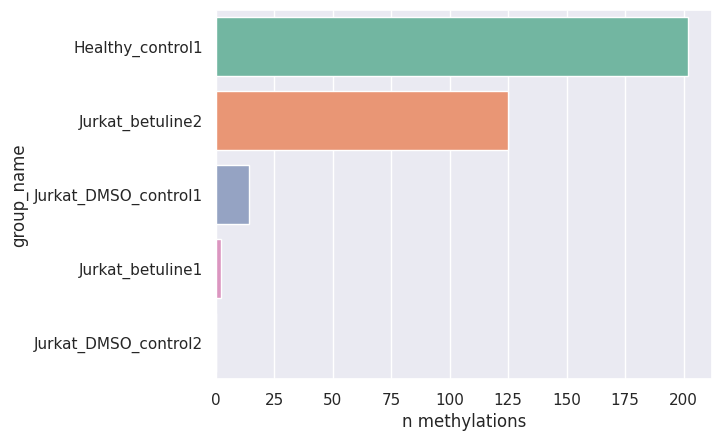

In [86]:
methylation_cdk1 = (df
                    .filter((pl.col("chr").is_in(df_cdk1.select("chr"))) &
                            (pl.col("start") >= df_cdk1.select("start").to_numpy()[0]) &
                            (pl.col("end") <= df_cdk1.select("end").to_numpy()[0])))
print(methylation_cdk1)



test_agg2: pl.DataFrame = (
    methylation_cdk1
    .select(["group_name", "frac"])
    .group_by("group_name")
    .agg([pl.len().alias("n methylations")])
    .join(all_groups, on="group_name", how="full")
    .with_columns(pl.col("group_name").fill_null(pl.col("group_name_right")))
    .drop("group_name_right") 
    .fill_null(0)
)
print(test_agg2.head())

sns.barplot(data = test_agg2.sort("n methylations", descending=True),
            y = "group_name", x = "n methylations",
            hue="group_name", palette="Set2")
plt.show()

This outputs a similar result to the first barplot
The only difference is that the annotation added an extra promoter area that has been connected to the CDK1 gene.
This is usable for now, but i'll have to ask Martijn if it is correct.
The next steps will be cleaning up a bit of my code